# Semi Parammetric Latent Factor Model

### Model   $Y=\phi * u + \sigma^2I$
##### Where, $\phi \in R ^{cxp}, u \in R^{pxn}$ and $Y \in R^{cxn}$
##### Also, $u_p \in GP(0,K^p)$ where $K^p$ is the covariance kernel for that particular gaussian process


In [122]:
### necessary Imports
import numpy as np
import pylab as pb
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as MNormalDist
import GPy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### True Model:

Here we generate our data that we can later use to check our solution

#### $\phi \in N(0,I)$

#### $u$
First we have similar kernels so that processes can be easily distinguished
We choose one as a exponential quad Kernel with shorter length scale.

Phi
[[-0.73596757  0.3407019   0.10948206]
 [-0.07415202  1.09891554  1.35841697]
 [ 1.25164936 -0.64459618  2.00482923]
 [ 0.23124228  1.09103014 -0.41580635]]


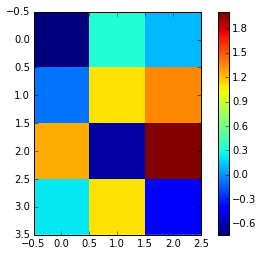

Kernels


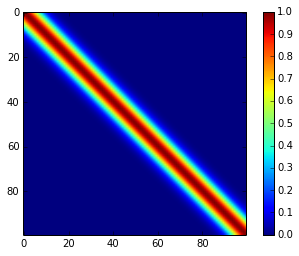

Latent Gaussian Processes:


 /home/nautiys1/.local/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning:covariance is not positive-semidefinite.


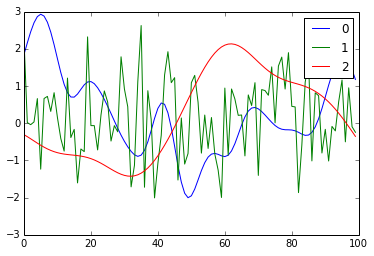

Output Values:


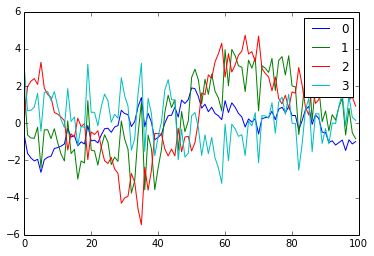

In [123]:
P = 3
C = 4
N = 100
s2 = 0.5
x = np.linspace(0,N-1,N)
phi = np.random.normal(loc=0,scale=1,size=(C,P))
print "Phi\n",phi
plt.imshow(phi,interpolation='none')
plt.colorbar()
plt.show()
print "Kernels"
K = list()
K.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=5))
K.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=0.5))
for i in range(3,11):
    K.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=10+i))
imshow(K[0],interpolation=None)       
plt.colorbar()
#Latent Gaussian Processes:
plt.show()
print "Latent Gaussian Processes:"
u = np.zeros((P,N))
for p in range(P):
    u[p,:] = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=K[p])
    plt.plot(u[p,:],label=p)
plt.legend()
# Output Values:
plt.show()
print "Output Values:"
s2 = 0
Y = phi.dot(u) + s2
for c in range(C):
    plt.plot(Y[c,:],label=c)
plt.legend()
plt.show()

### Kernel classes to be used to generate differnet Kernels for latent processes
#### We keep one with high and one low length scale to distinguish between them easily

In [124]:
class Kernel:
    @staticmethod
    def fetchParams(intializations,passed):
        params ={}
        for param in intializations:
            if param in passed:
                params[param] = passed[param]
            else:
                params[param] = intializations[param]
        return params
    
    @staticmethod
    def exponenQuad(x,xprime,a=1,l=0.5,**kwargs):
        if kwargs:
            if kwargs['a']:
                a = kwargs['a']
            if kwargs['l']:
                l = kwargs['l'] 
        return a*np.exp((-0.5*(x - xprime)**2)/l**2)
    
    @staticmethod
    def periodic(x,xprime,**kwargs):
        initializations = { 'a':1,
                            'p':0.5,
                            'l':0.5}
        params = Kernel.fetchParams(initializations,kwargs)
        return params['a']*np.exp((-2*np.sin(np.pi* np.abs(x-xprime)/(params['p'])**2))/(params['l']**2))
        
        
    @staticmethod
    def generateKernel(kernelFunc,x,xprime,**kwargs):
        kernel = np.zeros((x.size,xprime.size))
        for i in range(x.size):
            for j in range(xprime.size):
                kernel[i,j] = kernelFunc(x[i],xprime[j],**kwargs)
        return np.mat(kernel)

In [163]:
class SLFM:
    
    def __init__(self,Y,P,KernelFuncs=[]):
        self.Y = Y
        self.P = P
        self.C,self.N = Y.shape
        self.s2 = 0.5
        self.x = np.linspace(0,N-1,N)
        self.phi = np.random.normal(loc=0,scale=1,size=(C,P))
        if len(KernelFuncs) < self.P:
            self.KernelFuncs = SLFM.__generateRBFKernelFuncs(self.P)
    
    @staticmethod
    def __generateRBFKernelFuncs(P):
        kernels = []
        for p in range(P):
            kernels.append(Kernel.exponenQuad)
        return kernels
            
    def induced_variation_fit(n,optimizeInduction=False):
        self.noOfInductions = n
        if optimizeInduction:
            self.optimizeInduction()
        else:
            self.prepSparseVariationInference()
    
    ## Intialization for variational inference
    def prepSparseVariationInference(self,noOfInductions):
        self.n = sort(np.random.choice(self.x,size=noOfInductions,replace=False))
        # Create Matrices
        self.Knn = list()
        self.KNn = list()
        self.KnnInv = list()
        self.KNN = list()
        for i in range(P):
            self.Knn.append(Kernel.generateKernel(Kernel.exponenQuad,self.n,self.n,l=1,a=1))
            self.KNn.append(Kernel.generateKernel(Kernel.exponenQuad,self.x,self.n,l=1,a=1))
            self.KNN.append(Kernel.generateKernel(Kernel.exponenQuad,self.x,self.x,l=1,a=1))
            self.KnnInv.append(np.linalg.inv(self.Knn[i]))
        # Generate a guess for phi
        self.phiHatMean = 0
        self.phiHatV = 1
        self.phiHatExp = np.mat(np.random.normal(loc=self.phiHatMean,scale=self.phiHatV,size=(C,P)))
        #phiHatExp = phi
        self.phiHatVar = np.eye(P)
        self.uHatMeans = np.random.normal(loc=0,scale=1,size=(P,noOfInductions,1))
        self.uExp = np.random.normal(loc=0,scale=1,size=(P,N))
        self.uHatVs = list()
        self.uVar = list()
        self.Ups = list()
        self.Zps = list()
        self.initializeAll(noOfInductions)
    
    
    def initializeAll(self,noOfInductions):
        for p in range(self.P):
            Up,Zp = self.calculateUpZp(p)
            self.Ups.append(Up)
            self.Zps.append(Zp)
            self.uHatVs.append(np.eye(noOfInductions))
            self.uVar.append(np.eye(N))
            
    def calculateUpZp(self,p):
        #Find Up and Zp
        excludeP = np.arange(self.P)!=p
        #print i,p
        Zp = self.phiHatExp[:,p].T.dot(self.Y - self.phiHatExp[:,excludeP]*self.uExp[excludeP,:])
        phiSqHatExp = self.C*self.phiHatVar[p,p] + self.phiHatExp[:,p].T.dot(self.phiHatExp[:,p])
        Up = np.diagflat(np.multiply(np.ones(N) ,phiSqHatExp))
        return Up,Zp
            
    
    def displayGPs(self,gps,gpVars=None,ax=None):
        if ax == None:
            ax = plt
        for i in range(len(gps)):
            gp = gps[i]
            ax.plot(gp,label=i)
            if gpVars is not None:
                std = np.sqrt(np.diag(gpVars[i]))
                ax.fill_between(self.x,gp-std,gp+ std, alpha = 0.1,color='cyan')
        plt.legend()
        plt.show()
    
    def displayGuesses(self):
        fig,axes = plt.subplots(nrows = 1,ncols = 2, figsize=(18,8))
        im = axes[0].imshow(self.phiHatExp,interpolation='None')
        plt.colorbar(im,ax=axes[0])
        axes[0].set_title("Phi")
        for p in range(P):
            gp = self.uExp[p]
            axes[1].plot(self.x,gp)
            axes[1].set_title("Latent Process Guess")
            std = np.sqrt(np.diag(self.uVar[p]))
            axes[1].fill_between(self.x,gp-std,gp+ std, alpha = 0.2,color='cyan')
    
    def calculateLikelihood(self,p):
        uInv = np.linalg.inv(self.Ups[p])
        covMul = self.KNn[p]*self.KnnInv[p]*self.KNn[p].T
        logNterm = sum(MNormalDist.logpdf(x=uInv*self.Zps[p].T, mean=  np.zeros((self.N)),cov=uInv +covMul )) 
        summationForTrace = np.zeros((N,N))
        for i in range(P):
            covUiHat = self.KNN[i] - self.KNn[i]*self.KnnInv[i]*self.KNn[i].T
            summationForTrace += self.Ups[i]*covUiHat
        likl = logNterm - 0.5*np.matrix.trace(summationForTrace) 
        return likl
    
    def calculateTotalLikelihood(self):
        return sum([self.calculateLikelihood(p) for p in range(P)])
    
    
    def variation_fit(self):
        prevLikl = slfm.calculateTotalLikelihood()
        newLikl = 0
        while(abs(newLikl - prevLikl) > 0.002):
            #Updates for u's
            for p in range(P):
                Up,Zp = self.calculateUpZp(p)
                ###Update Up,Zp
                self.Ups[p] = Up
                self.Zps[p] = Zp
                KNKnInv = self.KNn[p]*self.KnnInv[p]
                SigmaP = self.KnnInv[p] + KNKnInv.T * Up *KNKnInv
                self.uHatVs[p] = SigmaP
                self.uHatMeans[p] = np.linalg.inv(SigmaP)*KNKnInv.T*Zp.T
                self.uExp[p] = (KNKnInv*self.uHatMeans[p]).reshape(1,N)
                SigmaUGvUp = self.KNN[p] - KNKnInv * self.KNn[p].T
                self.uVar[p] = SigmaUGvUp + KNKnInv*np.linalg.inv(SigmaP)*KNKnInv.T
            #Update Phi
            ## Variational Update for Phi
            Vf= self.uExp.dot(self.uExp.T)
            SigmaPhi = np.linalg.inv(Vf + np.eye(self.P))
            self.phiHatExp = np.mat(self.Y) * self.uExp.T * SigmaPhi
            self.phiHatVar = SigmaPhi
            #Find new likl
            if newLikl != 0:
                prevLikl = newLikl
            newLikl = self.calculateTotalLikelihood()
            #print abs(newLikl - prevLikl)

100


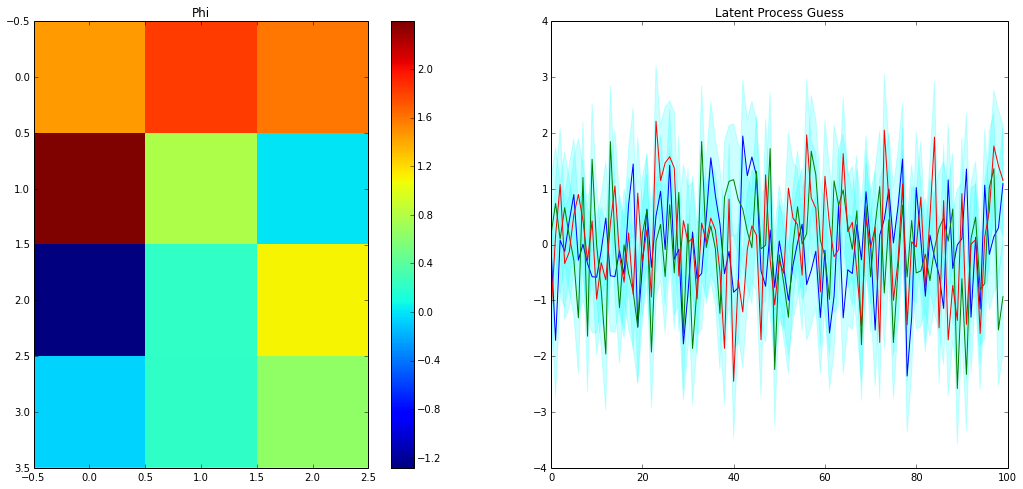

In [164]:
slfm = SLFM(Y,P)
slfm.prepSparseVariationInference(30)
slfm.displayGuesses()
print slfm.N

In [165]:
slfm.calculateTotalLikelihood()

-25426.118095297614

In [166]:
slfm.variation_fit()

7201.07255074
5510.36981897
1479.56565641
36.0487567102
416.367943015
391.624143757
366.145110158
328.834779696
286.487278207
246.007437609
209.903888841
178.709583573
152.197084306
129.872251665
111.177275971
95.5746394795
82.5796972236
71.7702436707
62.7857119444
55.3219291165
49.1242870609
43.9807142847
39.7150955943
36.1814076103
33.2586434088
30.846502144
28.8617744642
27.2353377124
25.9096729924
24.8368217324
23.9767082433
23.2957646304
22.7658040852
22.3630974251
22.0676155386
21.8624070728
21.7330863236
21.6674109572
21.6549330413
21.6867099942
21.7550646151
21.8533854148
21.9759601314
22.1178366494
22.2747066206
22.442807948
22.6188429934
22.7999099275
22.9834451002
23.1671746696
23.3490740338
23.5273338446
23.7003315896
23.8666078815
24.0248467377
24.173859237
24.3125700335
24.4400062857
24.5552886218
24.6576238138
24.7462988808
24.8206763786
24.8801906643
24.9243449532
24.9527090093
24.9649173307
24.9606677071
24.9397200474
24.9018953817
24.8470749638
24.7751994002
24.686267

In [167]:
slfm.calculateTotalLikelihood()

-27937.58480872876

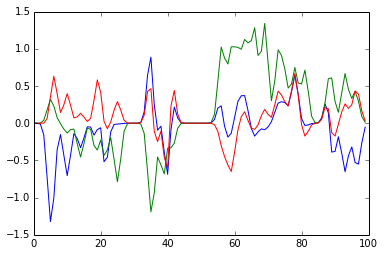

In [168]:
plt.plot(slfm.uExp.T)

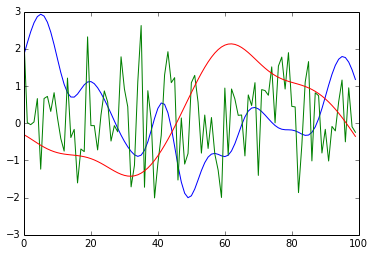

In [169]:
plt.plot(u.T)

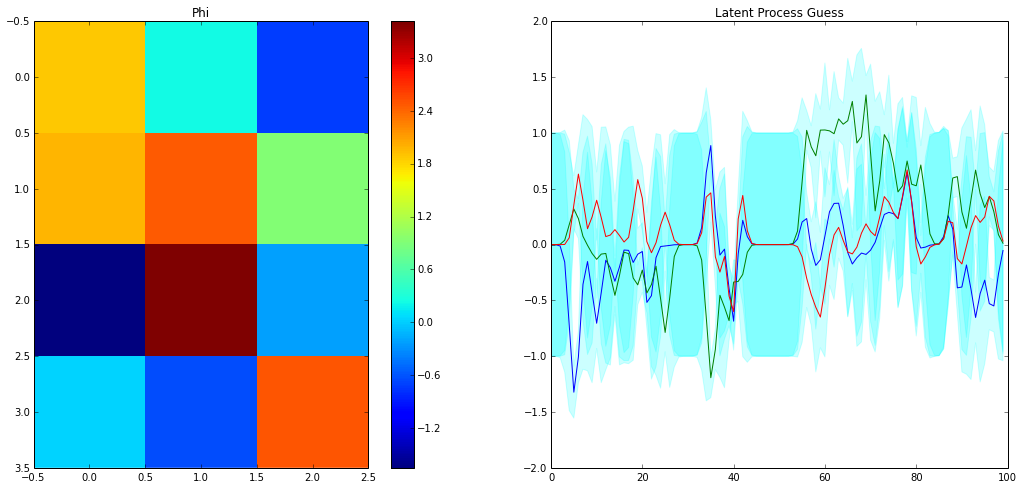

In [170]:
slfm.displayGuesses()

In [162]:
n

array([  0.,   1.,   3.,   6.,   7.,   8.,   9.,  10.,  11.,  16.,  17.,
        19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  28.,  29.,  30.,
        31.,  32.,  34.,  36.,  37.,  38.,  39.,  42.,  44.,  45.,  46.,
        47.,  49.,  50.,  52.,  53.,  55.,  57.,  59.,  60.,  61.,  62.,
        63.,  65.,  66.,  68.,  69.,  70.,  71.,  74.,  76.,  77.,  78.,
        79.,  80.,  81.,  82.,  83.,  84.,  85.,  88.,  89.,  91.,  92.,
        95.,  96.,  97.,  99.])

## Now objective is to variationally approximate and recover Phi 

Variational Inducing Updates are:


### Intialization for variational updaes

- Select random inducing points {Needs to be optimized later}
- Generate Kernels 
- Phi Prior: N(0,I)
- uHatMeans Just random PXn values sampled form N(0,1) 
- uExp: Just random PXN values sampled form N(0,1)

### Initial Guesses:
    

### Variational Updates are:

#### For U's:

$$\hat{u}_p = N(\Sigma_{p}^{-1}K_{n}^{-1}K_{Nn}Z_p,\Sigma_{p})$$
where $\Sigma_{p} = K_{n}^{-1} + \frac{1}{\sigma^2}K_{n}^{-1}K_{nN}UK_{Nn}K_{n}^{-1}$
and $Z_p = \sum_{c}^{C}<\phi_{cp}>(y_c - \sum_{i}^{P/p}<\phi_{ci}><u_{ip}>)$, 
and $U_p = \sum_{c}^{C}<\phi_{cp}^2>$

$<\phi_{cp}^2> = var(\phi_{cp}) - <\phi_{cp}>^2$ 


Also,Actual U is:

E[u] = $K_{Nn}K_{n}^{-1}\hat{\mu}_{p}$
where $\hat{\mu}_{p}$ is the mean of $\hat{u}_p$
and Variance as $\Sigma_{u|u^{p}} + M\Sigma_{p}M^{T}$

where $\Sigma_{u|u^{p}} = K_{N} - K_{Nn}K_{n}^{-1}K_{nN}$
and $M = K_{Nn}K_{n}^{-1}$

#### For $\phi$:

$\phi = N(yU^{T}\Sigma_{\phi}^{-1}, \Sigma_{\phi}^{-1})$
where $\Sigma_{\phi} = (V_{\phi} + I )$
and $V_{\phi} = <U><U>^T\sigma^2$

### And lower bound of liklelihood with respect to $u_p$ is given by:

$L(u_p) = log N(U_{p}^{-1}z_p| 0, U_{p}^{-1} + K_{Nn}K_{nn}^{-1}K_{nN}) - \frac{1}{2}tr(\sum_{i}^{P}{U_i*cov(u_i|\hat{u_i}}))$ - KL divergence terms.. 

where
$ cov(u_p|\hat{u}_p) = K_N - K_{Nn}K_{n}^{-1}K_{nN}$




In [117]:
noOfInductions = 70
n = sort(np.random.choice(x,size=noOfInductions,replace=False))
sparseY = np.mat(Y[:,n.astype(int)])
# Create Matrices
Knn = list()
KNn = list()
KnnInv = list()
KNN = list()
for i in range(P):
    Knn.append(Kernel.generateKernel(Kernel.exponenQuad,n,n,l=1,a=4))
    KNn.append(Kernel.generateKernel(Kernel.exponenQuad,x,n,l=1,a=4))
    KNN.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=1,a=4))
    KnnInv.append(np.linalg.inv(Knn[i]))
    print KNn[i].shape,Knn[i].shape,KnnInv[i].shape
# Generate a guess for phi
phiHatMean = 0
phiHatV = 1
phiHatExp = np.mat(np.random.normal(loc=phiHatMean,scale=phiHatV,size=(C,P)))
#phiHatExp = phi
phiHatVar = np.eye(P)
uHatMeans = np.random.normal(loc=0,scale=1,size=(P,noOfInductions,1))
uHatVs = [np.eye(noOfInductions)for p in range(P)]
uExp = np.random.normal(loc=0,scale=1,size=(P,N))
uVar = list()

(100, 70) (70, 70) (70, 70)
(100, 70) (70, 70) (70, 70)
(100, 70) (70, 70) (70, 70)


In [118]:
likelihoods = list()
for i in range(100):
    #Variational Update for Up:
    likl = list()
    for p in range(P):
        #Find Up and Zp
        excludeP = np.arange(P)!=p
        #print i,p
        Zp = (phiHatExp[:,p].T.dot(Y - phiHatExp[:,excludeP]*uExp[excludeP,:])).reshape(1,N)
        phiSqHatExp = C*phiHatVar[p,p] + phiHatExp[:,p].T.dot(phiHatExp[:,p])
        Up = np.diagflat(np.multiply(np.ones(N) ,phiSqHatExp))
        KNKnInv = KNn[p]*KnnInv[p]
        SigmaP = KnnInv[p] + KNKnInv.T * Up *KNKnInv
        uHatMeans[p] = (np.linalg.inv(SigmaP)*KNKnInv.T*Zp.T).reshape(noOfInductions,1)
        uExp[p] = (KNKnInv*uHatMeans[p]).reshape(1,N)
        SigmaUGvUp = KNN[p] - KNKnInv * KNn[p].T
        uVar.append(SigmaUGvUp + KNKnInv*SigmaP*KNKnInv.T)
        #likl.append(calculateLikelihood(p))
    ## Variational Update for Phi
    Vf= uExp.dot(uExp.T)
    SigmaPhi = np.linalg.inv(Vf + np.eye(P))
    phiHatExp = np.mat(Y) * uExp.T * SigmaPhi
    phiHatVar = SigmaPhi
    #likelihoods.append(likl)
#displayGuesses(uExp=uExp,phiHatExp=phiHatExp)

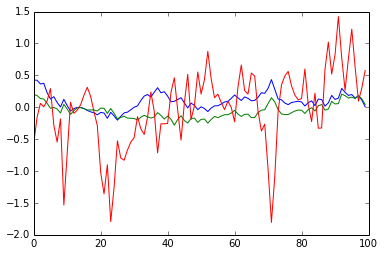

In [121]:
plt.plot(-1*uExp.T)

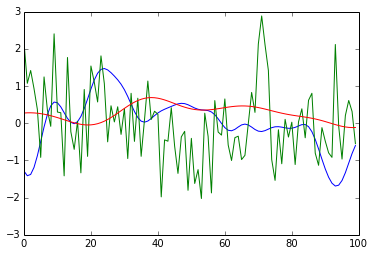

In [120]:
plt.plot(u.T)

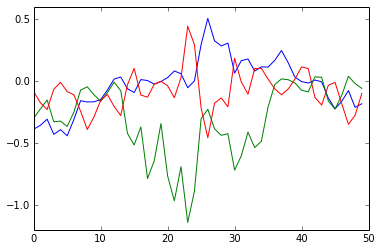

In [92]:
plt.plot(slfm.uExp.T)

In [ ]:
likl1 = slfm.calculateTotalLikelihood()
likl2 = 0
while(likl2 - likl1 > 0.02):
    #Updates for u's
    for p in range(P):
        Up,Zp = self.calculateUpZp(p)
        KNKnInv = KNn[p]*KnnInv[p]
        SigmaP = KnnInv[p] + KNKnInv.T * Up *KNKnInv
        self.uHatMeans[p] = (np.linalg.inv(SigmaP)*KNKnInv.T*Zp.T).reshape(self.n,1)
        self.uExp[p] = (KNKnInv*self.uHatMeans[p]).reshape(1,self.N)
        SigmaUGvUp = self.KNN[p] - KNKnInv * self.KNn[p].T
        self.uVar[p] = SigmaUGvUp + KNKnInv*SigmaP*KNKnInv.T
    #Update Phi
    ## Variational Update for Phi
    Vf= self.uExp.dot(uExp.T)
    SigmaPhi = np.linalg.inv(Vf + np.eye(P))
    self.phiHatExp = np.mat(self.Y) * self.uExp.T * SigmaPhi
    self.phiHatVar = SigmaPhi
    #Find new likl
    newl = self.calculateTotalLikelihood()
    likl1 = likl2
    likl2 = newl

In [120]:
for i in range(100):
    #Variational Update for Up:
    likliHood = list()
    for p in range(P):
        #Find Up and Zp
        excludeP = np.arange(P)!=p
        #print i,p
        Zp = (phiHatExp[:,p].T.dot(Y - phiHatExp[:,excludeP]*uExp[excludeP,:])).reshape(1,N)
        phiSqHatExp = C*phiHatVar[p,p] + phiHatExp[:,p].T.dot(phiHatExp[:,p])
        Up = np.diagflat(np.multiply(np.ones(N) ,phiSqHatExp))
        Ups.append(Up)
        Zps.append(Zp)
        KNKnInv = KNn[p]*KnnInv[p]
        SigmaP = KnnInv[p] + KNKnInv.T * Up *KNKnInv
        uHatMeans[p] = (np.linalg.inv(SigmaP)*KNKnInv.T*Zp.T).reshape(noOfInductions,1)
        uExp[p] = (KNKnInv*uHatMeans[p]).reshape(1,N)
        SigmaUGvUp = KNN[p] - KNKnInv * KNn[p].T
        uVar[p] = SigmaUGvUp + KNKnInv*SigmaP*KNKnInv.T
        likliHood.append(calculateLikelihood(Up,Zp,p))
    ## Variational Update for Phi
    Vf= uExp.dot(uExp.T)
    SigmaPhi = np.linalg.inv(Vf + np.eye(P))
    phiHatExp = np.mat(Y) * uExp.T * SigmaPhi
    phiHatVar = SigmaPhi
    totalLikliHood = sum(likliHood)
    print totalLikliHood
displayGuesses(uExp=uExp,phiHatExp=phiHatExp)

NameError: name 'phiHatExp' is not defined

## Reconstruct the data :

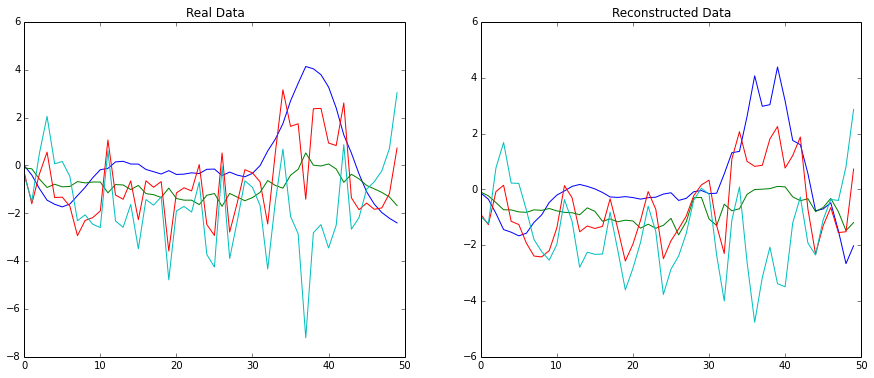

In [808]:

Ynew = phiHatExp * uExp
fig,axes = plt.subplots(nrows=1,ncols = 2,figsize=(15,6))
axes[0].plot(Y.T)
axes[0].set_title('Real Data')
#axes[0].scatter(n,np.zeros(n.size))
axes[1].plot(Ynew.T)
axes[1].set_title('Reconstructed Data')

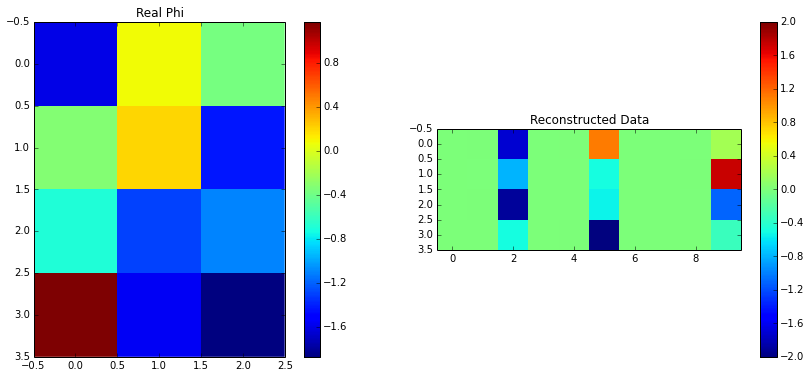

In [809]:
fig,axes = plt.subplots(nrows=1,ncols = 2,figsize=(15,6))
im = axes[0].imshow(phi, interpolation="None")
plt.colorbar(im,ax=axes[0])
axes[0].set_title('Real Phi')
#axes[0].scatter(n,np.zeros(n.size))
im = axes[1].imshow(phiHatExp, interpolation = "None",vmin=-2.0,vmax = 2.0)
plt.colorbar(im,ax=axes[1])
axes[1].set_title('Reconstructed Data')
#plt.colorbar(fig)

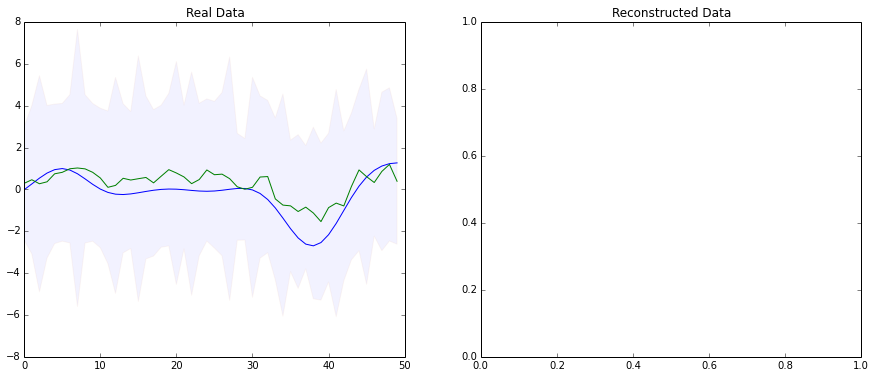

In [814]:
Ynew = phiHatExp * uExp
fig,axes = plt.subplots(nrows=1,ncols = 2,figsize=(15,6))
axes[0].plot(u[0].T)
uX = uExp[2].T
v = np.diag(uVar[2])
axes[0].plot(uX)
std = np.sqrt(v)
axes[0].fill_between(x=x, y1=uX-std, y2=uX+std,where = np.ones(len(x),np.bool),alpha=0.05, edgecolor='#CC4F1B')
axes[0].set_title('Real Data')
#axes[0].scatter(n,np.zeros(n.size))
#axes[1].plot(uExp.T)
axes[1].set_title('Reconstructed Data')

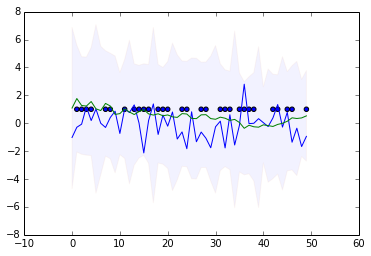

In [792]:
plt.plot(u[1].T)
plt.plot(uX)
fill_between(x=x, y1=uX-std, y2=uX+std,where = np.ones(len(x),np.bool),alpha=0.05, edgecolor='#CC4F1B')
plt.scatter(n,np.ones(len(n)))

In [820]:
sqrt(np.diag(uVar[2]))

array([ 2.7116009 ,  3.54765382,  5.16474427,  3.64789098,  3.3341624 ,
        3.29172047,  3.54481873,  6.62319811,  3.54485009,  3.29192614,
        3.33474018,  3.64864459,  5.1645312 ,  3.56200984,  3.27198627,
        5.86803575,  3.89073031,  3.49940787,  3.39422959,  3.64520336,
        5.32867911,  3.43161422,  5.3332452 ,  3.64564973,  3.39718139,
        3.50765881,  3.90178316,  5.81745771,  2.55321057,  2.42858978,
        5.25945271,  3.878533  ,  3.64001282,  3.86966556,  5.30826084,
        3.14127173,  3.67465933,  2.9470699 ,  4.10199772,  3.75174547,
        3.55371638,  5.43134776,  3.58190646,  3.50715537,  3.86099717,
        5.14393898,  2.56251656,  3.78709111,  3.66134554,  3.0048518 ])

<matplotlib.colorbar.Colorbar instance at 0x7f765a7207a0>

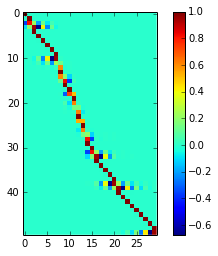

In [719]:
plt.imshow(A.T,interpolation="None")
plt.colorbar()

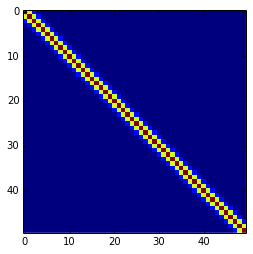

In [601]:
plt.imshow(KNN[0],interpolation="None")

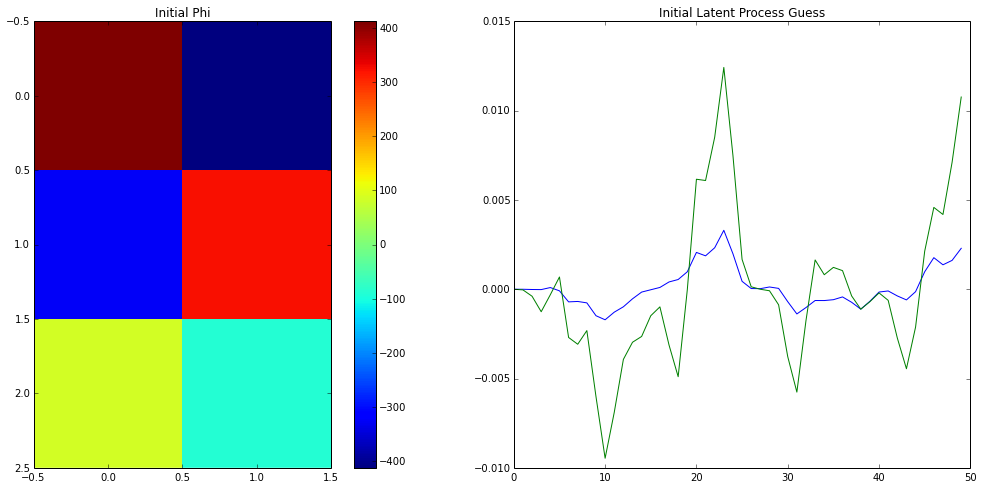

In [581]:
for i in range(2000):
    #print str(i)+" Variational Update\n"
    if i%5000 == 0:
        displayGuesses(phiHatExp,uExp)   
        plt.show()
    ## Variation Update for Phi
    Vf= uExp.dot(uExp.T)
    Sigmaf = np.mat(Vf + np.ones((P,P)))
    SigmafInv = np.linalg.inv(Sigmaf)
    phiHatExp = np.mat(Y) * uExp.T * SigmafInv
    phiHatVar = SigmafInv 
    ## Variation Update for Up:
    for p in range(P):
        #Find Up and Zp
        #Find summation terms
        Zp = np.mat(np.zeros((1,N)))
        Up = 0
        excludeP = np.arange(P)!=p
        for c in range(C):
            errTerm = Y[c,:] - phiHatExp[c,excludeP].dot(uExp[excludeP,:])
            #print errTerm.shape
            Zp += phiHatExp[c,p] * errTerm
            Up += phiHatVar[p,p] + phiHatExp[c,p]**2
        Up = np.diag(np.ones(N)*Up)
        #print Up
        SigmaP = KnnInv[p] + KnnInv[p] * KNn[p].T * Up * KNn[p] * KnnInv[p]
        uHatMeans[p] = (np.linalg.inv(SigmaP)*KnnInv[p]*KNn[p].T*Zp.T).reshape(noOfInductions,1)
        uExp[p] = (KNn[p]*KnnInv[p]*uHatMeans[p]).reshape(1,N)


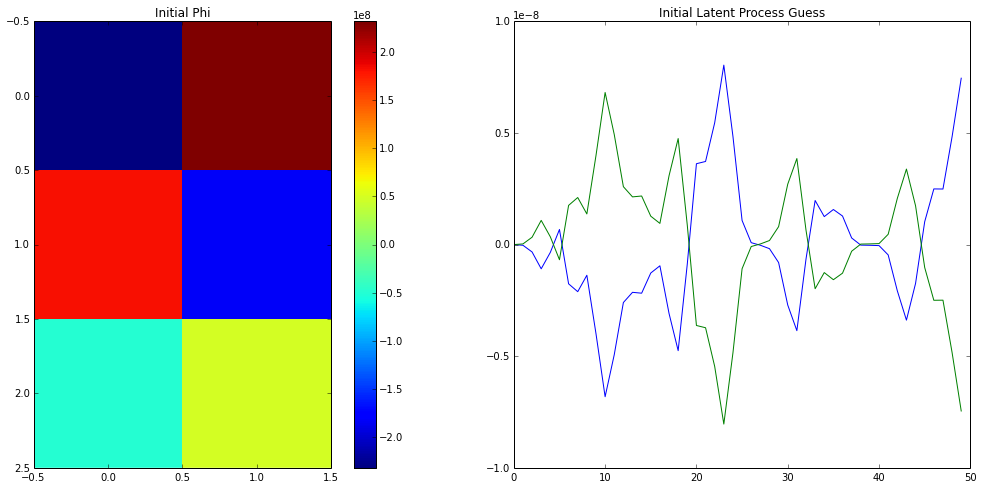

In [582]:
displayGuesses(phiHatExp,uExp) 

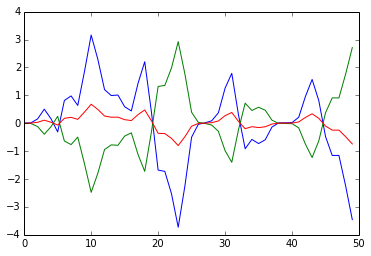

In [583]:
plt.plot((phiHatExp*uExp).T)

In [173]:
Sf = np.linalg.inv(Vf)+ np.ones((2,2))
Sf 

array([[ 1.,  1.],
       [ 1.,  1.]])

In [153]:
np.mat(Y) * (uExp.T.dot(np.linalg.inv(Sf)))


matrix([[ 11.61715198, -10.59765236],
        [  6.44606139,  -5.3463045 ],
        [  5.48105373,  -2.67810446]])

In [151]:
Y

array([[ 4.64519365,  2.56367635,  0.00488324,  1.33600743,  2.5538651 ],
       [ 1.05487813,  0.36760602, -0.43763771,  0.04414161,  0.47254206],
       [-4.42826158, -3.37688002, -1.91219272, -2.40076735, -2.90161002]])

In [114]:
uExp

array([[ 0.15541363, -1.14790487,  0.11584469, -0.08208878, -0.31761031],
       [ 0.8367871 ,  1.38948242,  0.84947795, -0.88028957,  0.72492445]])

In [117]:
uExp

array([[-2.99845375, -0.74084784, -2.21832938, -2.28190782, -0.60758936],
       [ 1.26096779,  1.50146389,  0.58508206, -0.01550615, -0.03230913]])

In [317]:
print np.linalg.inv(SigmaP).shape,KnnInv[p].shape,KnN[p].shape,Zp.T.shape

(20, 20) (20, 20) (20, 50) (20, 1)


In [311]:
Yhat = Y[:,n.astype(int)]

In [312]:
Yhat

array([[ 1.54891182,  1.54891182,  1.54891182,  1.54891182,  1.54891182,
         1.54891182,  1.54891182,  1.54891182,  1.54891182,  1.54891182,
         1.54891182,  1.54891182,  1.54891182,  1.54891182,  1.66628876,
         1.54891182,  1.54891182,  1.54891182,  1.54891182,  1.54891182],
       [ 1.75082811,  1.75082811,  1.75082811,  1.75082811,  1.75082811,
         1.75082811,  1.75082811,  1.75082811,  1.75082811,  1.75082811,
         1.75082811,  1.75082811,  1.75082811,  1.75082811,  1.70976584,
         1.75082811,  1.75082811,  1.75082811,  1.75082811,  1.75082811],
       [-1.28455901, -1.28455901, -1.28455901, -1.28455901, -1.28455901,
        -1.28455901, -1.28455901, -1.28455901, -1.28455901, -1.28455901,
        -1.28455901, -1.28455901, -1.28455901, -1.28455901, -1.99535756,
        -1.28455901, -1.28455901, -1.28455901, -1.28455901, -1.28455901]])